In [1]:
from dotenv import load_dotenv
import os

load_dotenv()

twitter_bearer_token = os.getenv('TW_BEARER_TOKEN')

from langchain.document_loaders import TwitterTweetLoader

In [2]:
def get_users_twitter(file: str) -> list:
    with open(file, 'r') as f:
        usernames = f.read().splitlines()
    return usernames

In [3]:
loader = TwitterTweetLoader.from_bearer_token(
    oauth2_bearer_token=twitter_bearer_token,
    twitter_users=get_users_twitter('/mnt/c/Users/kozan/Desktop/Sen_Des_Proj/GPT-4-KZEngine-Signal-Interpretation/twitter-sentiment/list_users_twitter.txt'),
    number_tweets=100,  # Default value is 100
)

In [ ]:
contents = []
documents = loader.load()
for doc in documents:
    contents.append(doc.dict())
len(contents)

In [ ]:
import pandas as pd

df = pd.DataFrame(contents)

df['created_at'] = pd.to_datetime(df['metadata'].apply(lambda x: x['created_at']), format='%a %b %d %H:%M:%S %z %Y')
df['screen_name'] = df['metadata'].apply(lambda x: x['user_info']['screen_name'])
df = df[['screen_name', 'page_content', 'created_at']]
df = df.rename(columns={'page_content': 'text', 'screen_name': 'username'})

In [ ]:
def cleaning_tweet_data( df: pd.DataFrame()):
    import re
    df_tweets = df.copy()
    if 'Unnamed: 0' in df_tweets.columns:
        df_tweets.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
    if 'source' in df_tweets.columns:
        df_tweets.drop(columns=['source', 'name', 'location', 'verified', 'description'], axis=1, inplace=True)
        

    df_tweets = df_tweets.apply(lambda x: x.astype(str).str.lower()).drop_duplicates(subset=['text', 'username'],
                                                                                        keep='first')
    
    df_tweets['text'] = df_tweets['text'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
    df_tweets['text'] = df_tweets['text'].str.lower()
    df_tweets['text'] = df_tweets['text'].str.replace("@[a-z0-9A-Z]+", "", regex=True)
    df_tweets['text'] = df_tweets['text'].str.replace("#[a-z0-9A-Z]+", "", regex=True)

    blanks = []  # start with an empty list
    for i, created_at, text, *username in df_tweets.itertuples():
        if type(text) == str:
            if text.isspace():
                blanks.append(i)
    df_tweets.drop(blanks, inplace=True)
    df_tweets.dropna(inplace=True)

    return df_tweets

In [ ]:
df['username'] = df['username'].astype(str)
df['text'] = df['text'].astype(str)
df.info()

In [ ]:
def preprocessing_tweet_datetime(df: pd.DataFrame()) -> pd.DataFrame():
    """
    For adding datetime groups Date, Hour, Minute to existing Dataframe.
        It uses to copy of existing Dataframe
    Args:
        self (tsa) 
        df (DataFrame)

    Returns:
        DataFrame
    """
    df_temp = df.copy()
    # Fixed for some blank tweets: 'tweets'. Interesting api result delete below with function
    df_temp.drop(df_temp[df_temp.created_at == 'twitter'].index, inplace=True)
    df_temp.created_at = pd.to_datetime(df_temp.created_at)
    df_temp['Date'] = df_temp.created_at.apply(lambda x: x.date())
    df_temp['hour'] = df_temp.created_at.apply(lambda x: x.hour)
    df_temp['minute'] = df_temp.created_at.apply(lambda x: x.minute)
    return df_temp

In [ ]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
def get_vader_sentiment( score):
    """
    Return to float sentiment score to with Positive, Neurtal and Negative label
    Args:
        self (tsa) 
        score (float)

    Returns: str
    """
    if score >= 0.05:
        return "Positive"
    elif 0.05 > score > -0.05:
        return "Neutral"
    elif score <= -0.05:
        return "Negative"
    return score

def get_sentiment_scores(df: pd.DataFrame()):
    df_temp = df.copy()
    df_temp['scores'] = df_temp['text'].apply(lambda review: sid.polarity_scores(review))
    df_temp['compound'] = df_temp['scores'].apply(lambda score_dict: score_dict['compound'])
    df_temp['comp_score'] = df_temp['compound'].apply(lambda score: get_vader_sentiment(score))

    return df_temp

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/kozan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
import numpy as np
def add_datetime_to_col(df: pd.DataFrame()) -> None:
    df['Datetime'] = np.nan
    for i in df.index:
        if df.hour[i] < 10:
            df.loc[i, 'Datetime'] = pd.to_datetime(f'{str(df.Date[i])} 0{str(df.hour[i])}:00+00:00')
        else:
            df.loc[i, 'Datetime'] = pd.to_datetime(f'{str(df.Date[i])} {str(df.hour[i])}:00+00:00')

In [ ]:
df = cleaning_tweet_data(df)
df = preprocessing_tweet_datetime(df)
df = get_sentiment_scores(df)
add_datetime_to_col(df)
df

,username,text,created_at,Date,hour,minute,scores,compound,comp_score,Datetime
0,trader1sz,$matic - this could get messy if blue box and ...,2023-07-24 15:39:33+00:00,2023-07-24,15,39,"{'neg': 0.295, 'neu': 0.705, 'pos': 0.0, 'comp...",-0.5574,Negative,2023-07-24 15:00:00+00:00
1,trader1sz,nobody puts that much effort into hastags as ...,2023-07-24 15:32:53+00:00,2023-07-24,15,32,"{'neg': 0.0, 'neu': 0.784, 'pos': 0.216, 'comp...",0.2960,Positive,2023-07-24 15:00:00+00:00
2,trader1sz,added more to $xrp shorts for some of their co...,2023-07-24 15:27:04+00:00,2023-07-24,15,27,"{'neg': 0.236, 'neu': 0.764, 'pos': 0.0, 'comp...",-0.5267,Negative,2023-07-24 15:00:00+00:00
3,trader1sz,how the fuck is that racism ...you're worse th...,2023-07-24 15:23:11+00:00,2023-07-24,15,23,"{'neg': 0.605, 'neu': 0.395, 'pos': 0.0, 'comp...",-0.8934,Negative,2023-07-24 15:00:00+00:00
4,trader1sz,system keeps telling me to leave everything el...,2023-07-24 15:22:01+00:00,2023-07-24,15,22,"{'neg': 0.062, 'neu': 0.821, 'pos': 0.118, 'co...",0.2732,Positive,2023-07-24 15:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...
2570,timstolte98,"as pointed out by statistical research, the ...",2022-09-05 14:17:19+00:00,2022-09-05,14,17,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral,2022-09-05 14:00:00+00:00
2571,timstolte98,i was not aware of the book and it does soun...,2022-09-05 14:15:31+00:00,2022-09-05,14,15,"{'neg': 0.0, 'neu': 0.743, 'pos': 0.257, 'comp...",0.6369,Positive,2022-09-05 14:00:00+00:00
2572,timstolte98,spurious regressions are really abstract and...,2022-09-05 11:24:50+00:00,2022-09-05,11,24,"{'neg': 0.191, 'neu': 0.809, 'pos': 0.0, 'comp...",-0.2100,Negative,2022-09-05 11:00:00+00:00
2573,timstolte98,"eventually, we see that the model fails. wro...",2022-09-05 11:24:37+00:00,2022-09-05,11,24,"{'neg': 0.312, 'neu': 0.688, 'pos': 0.0, 'comp...",-0.7096,Negative,2022-09-05 11:00:00+00:00


In [ ]:
def get_sent_with_mean_interval(df_tweets: pd.DataFrame(), interval: str = '1h') -> pd.DataFrame():
    df_result = pd.DataFrame()
    df_result['Datetime'] = df_tweets.Datetime.unique()
    df_result['sentiment_score'] = 0
    for i, dt, com in df_result.itertuples():
        sub_df = df_tweets.copy()
        df_result.loc[i, 'sentiment_score'] = sub_df.loc[
            (sub_df.Datetime.unique()[i] == sub_df.Datetime), 'compound'].mean()
    df_result.set_index('Datetime', inplace=True)
    df_result = df_result.sort_values('Datetime')
    if interval == '1d':
        df_result = df_result.resample('D').mean().reset_index()
        df_result.set_index('Datetime', inplace=True)
        df_result = df_result.sort_values('Datetime')
    df_result = df_result.dropna(axis=0)
    return df_result

<Axes: xlabel='Datetime'>

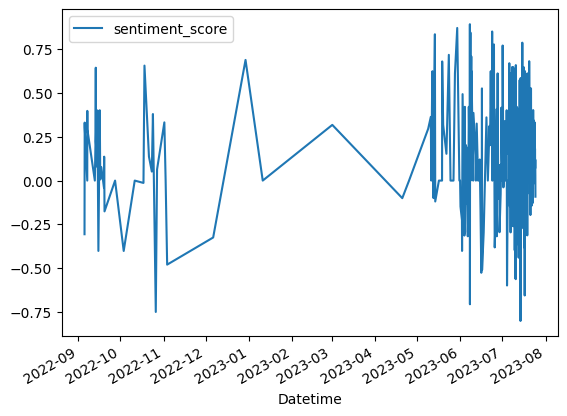

In [ ]:
import matplotlib.pyplot as plt
sent_scores = get_sent_with_mean_interval(df, '1h')
sent_scores.plot()

In [ ]:
from pandas.tseries.offsets import DateOffset

last_month_start = sent_scores.index.max() - DateOffset(months=1)
last_month_scores = sent_scores[sent_scores.index >= last_month_start]['sentiment_score']

<Axes: xlabel='Datetime'>

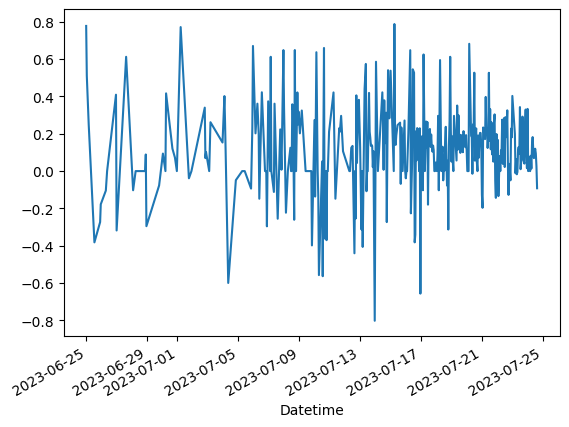

In [ ]:
last_month_scores.plot()